# Examen práctico Series de Tiempo
## Mary Yuliana Jaramillo
### Maestría en Ciencia de Datos - Semestre II
### https://github.com/maryyuliana

## 1. Carga de paquetes

In [9]:
import numpy as np
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
from statsmodels.tsa.seasonal import seasonal_decompose

## 2 Cargar de datos

In [25]:
url ="https://raw.githubusercontent.com/maryyuliana/FUNDAMENTOS_DE_ANALITICA_II/master/Examen.csv"
df = pd.read_csv(url, delimiter=',')
df = df.rename(columns={"Unnamed: 0": "Mes"})
df

,Mes,producto1,producto2
0,1,4000.000000,3000.000000
1,2,3997.400893,3010.686220
2,3,3978.605317,3022.018584
3,4,3986.454125,3033.920990
4,5,3979.695678,3038.402098
...,...,...,...
122,123,3664.610771,3429.293034
123,124,3650.881839,3437.099467
124,125,3651.788470,3453.155282
125,126,3637.047639,3472.528345


## 3.Análisis gráfico de la serie

### 3.1 Gráfico de las series

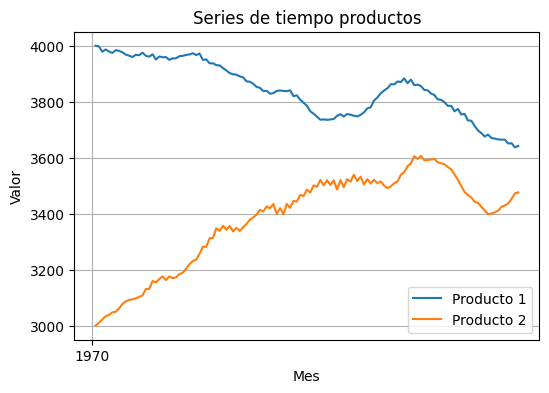

In [23]:
df['Mes'] = pd.to_datetime(df['Mes'])

# Graficar las dos series de tiempo
plt.figure(figsize=(6, 4))  # Definir tamaño de la figura
plt.plot(df['Mes'], df['producto1'], label='Producto 1')
plt.plot(df['Mes'], df['producto2'], label='Producto 2')

# Añadir etiquetas y título
plt.xlabel('Mes')
plt.ylabel('Valor')
plt.title('Series de tiempo productos')
plt.grid(True)  # Agregar cuadrícula
plt.legend()  # Mostrar leyenda

# Mostrar la gráfica
plt.show()

### 3.2 Descomposición de las series de tiempo

In [24]:


# Convertir la columna 'Mes' en tipo datetime
df['Mes'] = pd.to_datetime(df['Mes'])

# Establecer la columna 'Mes' como índice
df.set_index('Mes', inplace=True)

# Calcular la frecuencia de los datos
freq = pd.infer_freq(df.index)

# Realizar la descomposición estacional con la frecuencia calculada
td_componentes = seasonal_decompose(df['producto1'], model="additive")

# Graficar los componentes
fig = td_componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

ValueError: freq N not understood. Please report if you think this is in error.